In [ ]:
# Isotropic Schwarzschild BH example
# see further details in https://github.com/GRChombo/engrenage/wiki/Running-the-black-hole-example

# restart the kernel to clear past work
# (can also do this manually from the Kernel options above)
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [6]:
# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
sys.path.append('../')
from source.rhsevolution import *              # go here to look at how the evolution works
from source.bhinitialconditions import *       # go here to change the initial conditions
from source.hamdiagnostic import *             # go here to change the Ham constraint diagnostic
from source.Grid import *

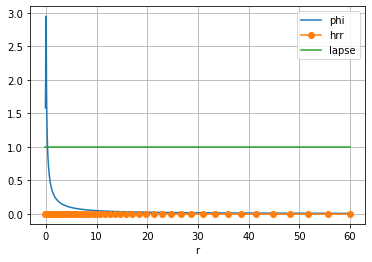

In [19]:
# Input parameters for grid and evolution here
max_r = 60.0
num_points = 64
N = num_points
log_factor = 1.075
my_grid = Grid(max_r, num_points, log_factor)
r = my_grid.r_vector

initial_state = get_initial_state(my_grid)

#unpackage the vector for readability
(initial_u, initial_v , initial_phi, initial_hrr, initial_htt, initial_hpp, 
 initial_K, initial_arr, initial_att, initial_app, 
 initial_lambdar, initial_shiftr, initial_br, initial_lapse) = np.array_split(initial_state, NUM_VARS)

#plot initial conditions
plt.xlabel('r')
#plt.plot(r, initial_u, label='u')
#plt.plot(r, initial_v, label='v')
#plt.plot(r, initial_arr, label='arr')
#plt.plot(r, initial_att, label='att')
#plt.plot(r, initial_K, label='K')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, '-o', label='hrr') # zero, but plot as dots to see the grid
plt.plot(r, initial_lapse, label='lapse')
#plt.plot(r, initial_lambdar, label='lambdar')
plt.legend(loc='best')
#plt.xlim(-1.2,1.2)
#plt.ylim(-0.001,0.001)
plt.grid()

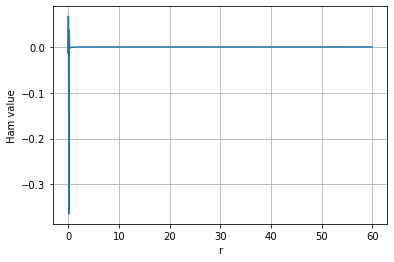

In [20]:
# check the Hamiltonian constraint initially satisfied
Ham = get_Ham_diagnostic(initial_state, np.array([0]), my_grid)

# plot the profile for Ham
plt.plot(r, Ham[0])

plt.xlabel('r')
#plt.xlim(-0.5,R+2)
#plt.ylim(-0.1,0.1)
plt.ylabel('Ham value')
plt.grid()

In [21]:
# for control of time integrator and spatial grid
T = 10.0 # Maximum evolution time
N_t = 64 # time resolution (only for outputs, not for integration, which is decided by python)

# Work out dt and time spacing of outputs
dt = T/N_t
t = np.linspace(0, T-dt, N_t)
eta = 0.5 # the 1+log slicing damping coefficient - of order 1/M_adm of spacetime

# Solve for the solution using RK45 integration of the ODE
# to make like (older) python odeint method use method='LSODA' instead
# use tqdm package to track progress
with tqdm(total=1000, unit="‰") as progress_bar:
    dense_solution = solve_ivp(get_rhs, [0,T], initial_state, 
                               args=(my_grid, eta, progress_bar, [0, T/1000]),
                        #atol=1e-5, rtol=1e-5,
                        #max_step=(0.1*R/N_r), #for stability
                        method='RK45', dense_output=True)

# Interpolate the solution at the time points requested
solution = dense_solution.sol(t).T

100%|███████████████████████████████████████| 1000/1000 [00:05<00:00, 178.07‰/s]


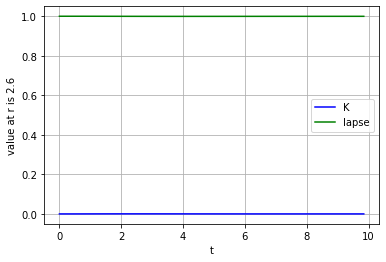

In [18]:
# Plot a single point versus time
var1 = idx_K
var2 = idx_lapse

idx = num_ghosts+20
r_i = np.round(r[idx],2)
var1_of_t = solution[0:N_t, var1 * (N) + idx]
plt.plot(t, var1_of_t, 'b-', label=variable_names[var1])
var2_of_t = solution[0:N_t, var2 * (N) + idx]
plt.plot(t, var2_of_t, 'g-', label=variable_names[var2])
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

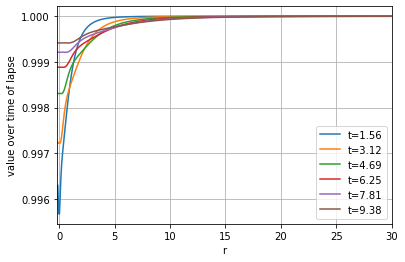

In [23]:
# plot the profile for some variable at a selection of times
var = idx_lapse # I suggest looking at shiftr, lapse, K or phi to see the gauge evolution

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 10 == 0) and (t_i > 0.0):
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * N: (var + 1) * N]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.xlim(-0.2,30.0)
plt.ylabel('value over time of ' + variable_names[var])
plt.grid()

In [24]:
# calculate the diagnostics, just the Hamiltonian constraint for now
Ham = get_Ham_diagnostic(solution, t, my_grid)

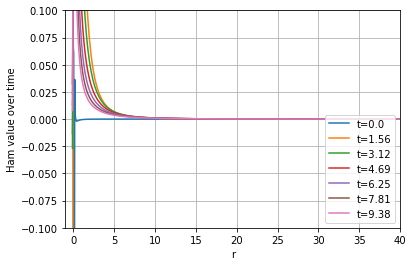

In [26]:
# plot the profile for Ham at a selection of times

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 10 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i]
        plt.plot(r, Ham_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.xlim(-1,40)
plt.ylim(-0.1,0.1)
plt.ylabel('Ham value over time')
plt.grid()